### Fix: Winsorizing Monthly Returns

When we build portfolios month by month, the **average return** for a month can be **badly distorted by extreme outliers** — for example:
- A bankrupt company suddenly dropping –90%
- A penny stock jumping +800%  
- A merger deal causing one stock to spike +300%

Even though we filtered for common stocks, **huge outlier returns still happen**, and they create **crazy noise** in the long-short return every month.

**Winsorization** solves this by **capping** extreme returns:
- For example, we could clip any stock return above **+100%** to **+100%**, and any return below **–100%** to **–100%**.
- (Or even more conservatively, clip at ±50% returns.)

This protects our monthly long-short return from being dominated by 1 or 2 crazy events.



Data prep:

In [64]:
import pandas as pd
df = pd.read_csv("../data/processed/full_similarity_with_returns.csv")

df = df.rename(columns={"filing_date": "month", "similarity": "similarity_score"})

df = df.dropna(subset=['similarity_score', 'tic', 'ret'])

df['month'] = pd.to_datetime(df['month'])

df

,cik,tic,month,similarity_score,ret
2,1750,air,1994-08-31,0.934598,-2.7027
3,1750,air,1994-10-31,0.928699,-4.8462
4,1750,air,1995-01-31,0.868299,1.8318
6,1800,abt,1994-05-31,0.934639,5.2863
7,1800,abt,1994-08-31,0.888515,6.6667
...,...,...,...,...,...
1299053,85535,rgld,2024-12-31,0.923907,-9.8523
1300115,1058811,immr,2024-12-31,0.985401,-2.3490
1300909,1393612,dfs,2024-12-31,0.977140,-5.0430
1300910,1393612,dfs,2024-12-31,0.998017,-5.0430


Stocks per month filter:

In [65]:
min_stocks_per_month = 100

month_counts = df['month'].value_counts()
valid_months = month_counts[month_counts >= min_stocks_per_month].index
df = df[df['month'].isin(valid_months)].copy()

print(f"after filtering, dataframe shape: {df.shape}")


after filtering, dataframe shape: (27662, 5)


### Winsorizing:

In [66]:

def winsorize_returns(group):
    lower = group['ret'].quantile(0.25)
    upper = group['ret'].quantile(0.995)
    group['ret'] = group['ret'].clip(lower, upper)
    return group

df = df.groupby('month', group_keys=False).apply(winsorize_returns)

print("Winsorization complete.")


Winsorization complete.


/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_33472/1484663254.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('month', group_keys=False).apply(winsorize_returns)


Hard-cap returns didn't work well

Quintiles

In [67]:
def custom_assign_quintile(group):
    group = group.sort_values('similarity_score', ascending=False).reset_index(drop=True)
    
    if len(group) == 2:
        group['quintile'] = [5, 1]  # Long top, short bottom
    else:
        group['quintile'] = pd.qcut(group.index, 5, labels=[5,4,3,2,1]).astype(int)
    
    return group

df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)

print("Quintiles assigned.")


Quintiles assigned.


/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_33472/1629635580.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)


In [68]:
df

,cik,tic,month,similarity_score,ret,quintile
0,77543,tpc,1994-05-31,0.999931,-1.03090,5
1,77543,tpc,1994-05-31,0.999931,-3.43125,5
2,66740,mmm,1994-05-31,0.997694,4.97960,5
3,96021,syy,1994-05-31,0.997097,-0.48080,5
4,795403,wts,1994-05-31,0.996169,-1.89360,5
...,...,...,...,...,...,...
578,310764,syk,2024-10-31,0.811373,-1.37850,1
579,1060822,cri,2024-10-31,0.809041,-7.80470,1
580,1103982,mdlz,2024-10-31,0.808797,-7.04490,1
581,85961,r,2024-10-31,0.794451,0.32920,1


Making Portfolios

In [69]:

portfolio_rets = []

for month, group in df.groupby('month'):
    long_ret = group.loc[group['quintile'] == 5, 'ret'].mean()
    short_ret = group.loc[group['quintile'] == 1, 'ret'].mean()
    long_short = long_ret - short_ret
    portfolio_rets.append({'month': month, 'portfolio_return': long_short})

portfolio_df = pd.DataFrame(portfolio_rets)
portfolio_df = portfolio_df.sort_values('month')

print("Monthly portfolio returns computed.")


Monthly portfolio returns computed.


In [70]:
portfolio_df

,month,portfolio_return
0,1994-05-31,-0.051703
1,1994-08-31,-0.501820
2,1994-11-30,-1.068947
3,1995-05-31,-0.659955
4,1995-06-30,0.801118
...,...,...
90,2024-02-29,1.781186
91,2024-04-30,-0.076531
92,2024-05-31,-2.296654
93,2024-09-30,-0.394045


Plot

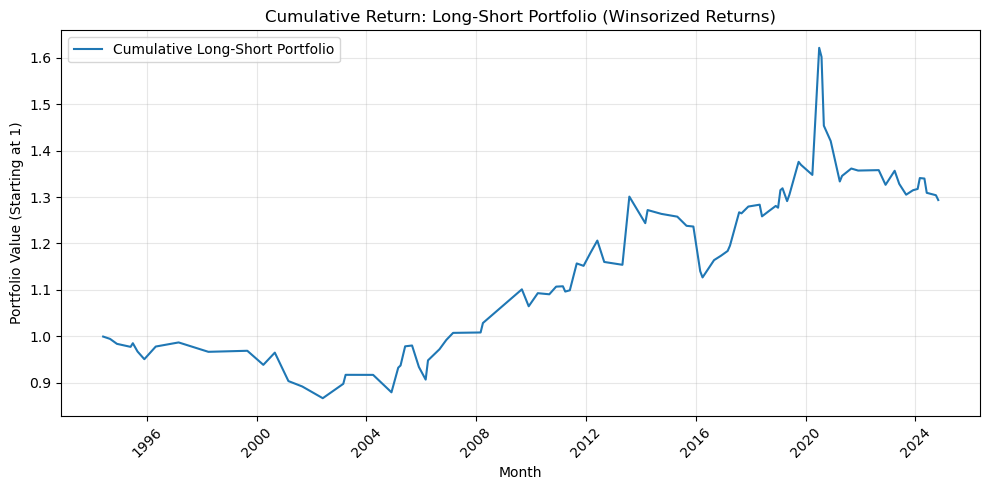

In [71]:
import matplotlib.pyplot as plt


portfolio_df['portfolio_return_decimal'] = portfolio_df['portfolio_return'] / 100
portfolio_df['cum_portfolio'] = (1 + portfolio_df['portfolio_return_decimal']).cumprod()

# Plot
plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['cum_portfolio'], label='Cumulative Long-Short Portfolio')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return: Long-Short Portfolio (Winsorized Returns)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [72]:
import numpy as np

# Load your portfolio returns if not already loaded
# portfolio_df = pd.read_csv('../data/processed/full_portfolio_returns_filtered.csv')

# 1. Calculate average monthly long-short return
mean_return = portfolio_df['portfolio_return_decimal'].mean()

# 2. Calculate standard deviation of monthly returns
std_dev = portfolio_df['portfolio_return_decimal'].std()

# 3. Calculate Sharpe ratio (annualized)
sharpe_ratio = (mean_return/ std_dev) * np.sqrt(12)  # 12 months per year

# 4. Print results
print(f"Average Monthly Return: {mean_return*100:.4f}%")
print(f"Monthly Return Std Dev: {std_dev*100:.4f}%")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")


Average Monthly Return: 0.3364%
Monthly Return Std Dev: 3.7001%
Annualized Sharpe Ratio: 0.3149
